In [72]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [73]:
img_dir = '../input/ocular-disease-recognition-odir5k/preprocessed_images'

In [74]:
data = pd.read_csv('../input/ocular-disease-recognition-odir5k/full_df.csv')
data[:10]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


In [75]:
data2 = data.iloc[:,7:15]
data2

,N,D,G,C,A,H,M,O
0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
6387,0,1,0,0,0,0,0,0
6388,0,1,0,0,0,0,0,0
6389,0,1,0,0,0,0,0,0
6390,0,1,0,0,0,0,0,0


In [76]:
data.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from collections import Counter


In [77]:
#Selecting columns from ID to Right Diagnostic keywords

In [78]:
data_copy = data.iloc[:,0:7]
data_copy.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [79]:
#Checking for word match 'cataract' in Left-Diagnostic Keywords

In [80]:
data_left = data_copy[data_copy['Left-Diagnostic Keywords'].str.match('cataract')]
data_left

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,119,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,254,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,294,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus
...,...,...,...,...,...,...,...
4697,2243,80,Male,2243_left.jpg,2243_right.jpg,cataract,cataract
4698,2246,69,Male,2246_left.jpg,2246_right.jpg,cataract,cataract
4699,2247,73,Male,2247_left.jpg,2247_right.jpg,cataract,cataract，lens dust
4700,2248,74,Female,2248_left.jpg,2248_right.jpg,cataract，lens dust,cataract，lens dust


In [81]:
#Checking for word match 'cataract' in Right-Diagnostic Keywords

In [82]:
data_right = data_copy[data_copy['Right-Diagnostic Keywords'].str.match('cataract')]
data_right

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract
...,...,...,...,...,...,...,...
4697,2243,80,Male,2243_left.jpg,2243_right.jpg,cataract,cataract
4698,2246,69,Male,2246_left.jpg,2246_right.jpg,cataract,cataract
4699,2247,73,Male,2247_left.jpg,2247_right.jpg,cataract,cataract，lens dust
4700,2248,74,Female,2248_left.jpg,2248_right.jpg,cataract，lens dust,cataract，lens dust


In Cataract problem, most of the cases are having cataract for one eye but normal for the other eye. 

In [83]:
#Combine both data
data_cataract = data_right['Right-Fundus'].append(data_left['Left-Fundus'], ignore_index = True)
data_cataract

0       24_right.jpg
1      112_right.jpg
2      188_right.jpg
3      218_right.jpg
4      354_right.jpg
           ...      
567    2243_left.jpg
568    2246_left.jpg
569    2247_left.jpg
570    2248_left.jpg
571    2262_left.jpg
Length: 572, dtype: object

In [84]:
len(data_cataract)

572

check few samples

In [85]:
data_cataract[141]

'2251_right.jpg'

(512, 512, 3)
2251_right.jpg


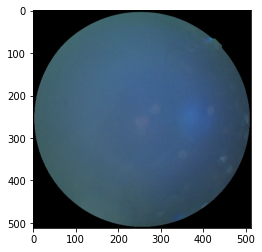

In [86]:
img = data_cataract[141]
image = cv2.imread(os.path.join(img_dir,img))
plt.imshow(image)
print(image.shape)
print(img)

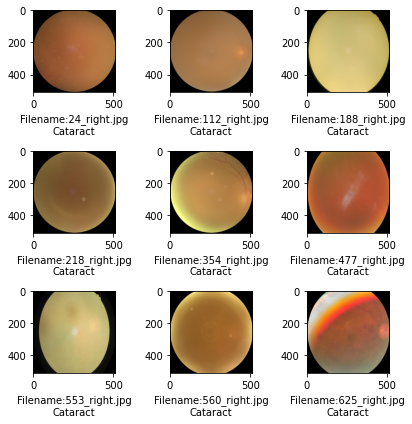

In [87]:
plt.figure(figsize = (6,6))
for i in range(9):
    img = data_cataract[i]
    image = cv2.imread(os.path.join(img_dir,img))
    rgb_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(rgb_image)
    plt.xlabel('Filename:{}\n''Cataract'.format(data_cataract[i]))
    plt.tight_layout()

Make a dataframe for normal images

In [88]:
data_ln = data_copy[data_copy['Left-Diagnostic Keywords'].str.match('normal')]
data_ln

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration
12,14,55,Male,14_left.jpg,14_right.jpg,normal fundus,macular epiretinal membrane
13,15,50,Male,15_left.jpg,15_right.jpg,normal fundus,myelinated nerve fibers
...,...,...,...,...,...,...,...
6356,4637,45,Male,4637_left.jpg,4637_right.jpg,normal fundus,normal fundus
6358,4639,60,Female,4639_left.jpg,4639_right.jpg,normal fundus,mild nonproliferative retinopathy
6360,4641,56,Male,4641_left.jpg,4641_right.jpg,normal fundus,mild nonproliferative retinopathy
6378,4672,65,Male,4672_left.jpg,4672_right.jpg,normal fundus,mild nonproliferative retinopathy


In [89]:
data_rn = data_copy[data_copy['Right-Diagnostic Keywords'].str.match('normal')]
data_rn

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus
24,29,59,Male,29_left.jpg,29_right.jpg,epiretinal membrane,normal fundus
...,...,...,...,...,...,...,...
6361,4642,52,Male,4642_left.jpg,4642_right.jpg,mild nonproliferative retinopathy,normal fundus
6363,4644,60,Female,4644_left.jpg,4644_right.jpg,mild nonproliferative retinopathy,normal fundus
6373,4660,51,Male,4660_left.jpg,4660_right.jpg,mild nonproliferative retinopathy,normal fundus
6377,4671,48,Male,4671_left.jpg,4671_right.jpg,mild nonproliferative retinopathy,normal fundus


In [93]:
#combine both
data_normal = data_rn['Right-Fundus'].append(data_ln['Left-Fundus'],ignore_index = True)
data_normal

0         0_right.jpg
1         1_right.jpg
2         8_right.jpg
3        10_right.jpg
4        29_right.jpg
            ...      
5585    4637_left.jpg
5586    4639_left.jpg
5587    4641_left.jpg
5588    4672_left.jpg
5589    4683_left.jpg
Length: 5590, dtype: object

In [94]:
len(data_normal)

5590

In [95]:
data_normal_rand = data_normal.sample(n=494)
data_normal_rand.head()
#since glaucoma cases are 494, taking 650 normal cases

828     2918_right.jpg
1097    3209_right.jpg
4483     2378_left.jpg
3448     2835_left.jpg
4032     4154_left.jpg
dtype: object

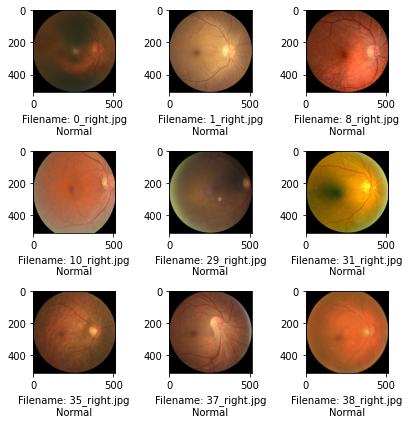

In [96]:
# Visualise few samples
plt.figure(figsize=(6,6))
for i in range(9):
    img = data_normal[i]
    image = cv2.imread(os.path.join(img_dir,img))
    rgb_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.imshow(rgb_image)
    plt.xlabel('Filename: {}\n''Normal'.format(data_normal[i]))
    plt.tight_layout()

In [97]:
print(type(data_normal_rand))

<class 'pandas.core.series.Series'>


Change both lists of normal and cataract to dataframes

In [98]:
cataract_df = pd.DataFrame(data_cataract, columns =['images'])
cataract_df

,images
0,24_right.jpg
1,112_right.jpg
2,188_right.jpg
3,218_right.jpg
4,354_right.jpg
...,...
567,2243_left.jpg
568,2246_left.jpg
569,2247_left.jpg
570,2248_left.jpg


In [99]:
#add label column as 'Glaucoma'
cataract_df['label'] = 'cataract'
cataract_df

,images,label
0,24_right.jpg,cataract
1,112_right.jpg,cataract
2,188_right.jpg,cataract
3,218_right.jpg,cataract
4,354_right.jpg,cataract
...,...,...
567,2243_left.jpg,cataract
568,2246_left.jpg,cataract
569,2247_left.jpg,cataract
570,2248_left.jpg,cataract


In [100]:
normal_df = pd.DataFrame(data_normal_rand,columns =['images'])
normal_df

,images
828,2918_right.jpg
1097,3209_right.jpg
4483,2378_left.jpg
3448,2835_left.jpg
4032,4154_left.jpg
...,...
1130,3244_right.jpg
3274,2638_left.jpg
4447,2340_left.jpg
247,1428_right.jpg


In [101]:
#add label column as 'normal'
normal_df['label'] = 'normal'
normal_df

,images,label
828,2918_right.jpg,normal
1097,3209_right.jpg,normal
4483,2378_left.jpg,normal
3448,2835_left.jpg,normal
4032,4154_left.jpg,normal
...,...,...
1130,3244_right.jpg,normal
3274,2638_left.jpg,normal
4447,2340_left.jpg,normal
247,1428_right.jpg,normal


In [102]:
#combine both
df_combined = cataract_df.append(normal_df, ignore_index= True)
df_combined

,images,label
0,24_right.jpg,cataract
1,112_right.jpg,cataract
2,188_right.jpg,cataract
3,218_right.jpg,cataract
4,354_right.jpg,cataract
...,...,...
1061,3244_right.jpg,normal
1062,2638_left.jpg,normal
1063,2340_left.jpg,normal
1064,1428_right.jpg,normal


Prior to feeding this organized set of cataract and normal images we need to randomize the rows within so that when we train we will train from a random pool of samples.

If we append, we end up adding a column for the old index values, which we don't want any new columns, so we'll drop the old index and allow the new dataframe to have a new one

In [103]:
df = df_combined.sample(frac=1).reset_index(drop=True)
df

,images,label
0,477_right.jpg,cataract
1,3088_left.jpg,normal
2,1285_left.jpg,cataract
3,809_left.jpg,cataract
4,2180_right.jpg,cataract
...,...,...
1061,3065_right.jpg,normal
1062,1415_right.jpg,cataract
1063,2709_right.jpg,normal
1064,2806_left.jpg,normal


In [104]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df))
print(len(df_train))
print(len(df_test))

1066
853
213


In [105]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [106]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [107]:
img_size =224

In [108]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="images",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="images",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="images",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 683 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 213 validated image filenames belonging to 2 classes.


In [109]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

In [110]:
train_labels[0]

array([1., 0.], dtype=float32)

In [111]:

#from imblearn.over_sampling import SMOTE
#x_train = pd.DataFrame(X_train)
#X_resample, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [112]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [113]:
checkpoint = ModelCheckpoint("cataract_vgg16.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')


In [114]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

21 5


In [115]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/30
21/21 [==============================] - 16s 636ms/step - loss: 1.5095 - accuracy: 0.5776 - val_loss: 0.4692 - val_accuracy: 0.8500

Epoch 00001: val_accuracy improved from -inf to 0.85000, saving model to cataract_vgg16.h5
Epoch 2/30
21/21 [==============================] - 15s 597ms/step - loss: 0.6888 - accuracy: 0.7250 - val_loss: 0.2780 - val_accuracy: 0.8875

Epoch 00002: val_accuracy improved from 0.85000 to 0.88750, saving model to cataract_vgg16.h5
Epoch 3/30
21/21 [==============================] - 16s 634ms/step - loss: 0.4799 - accuracy: 0.7926 - val_loss: 0.4149 - val_accuracy: 0.8062

Epoch 00003: val_accuracy did not improve from 0.88750
Epoch 4/30
21/21 [==============================] - 16s 630ms/step - loss: 0.4321 - accuracy: 0.8280 - val_loss: 0.2423 - val_accuracy: 0.9187

Epoch 00004: val_accuracy improved from 0.88750 to 0.91875, saving model to cataract_vgg16.h5
Epoch 5/30
21/21 [==============================] - 14s 556ms/step - loss: 0.3849 - accura

In [ ]:
from keras.models import load_model
model = load_model('../input/cataract_vgg16.h5"')


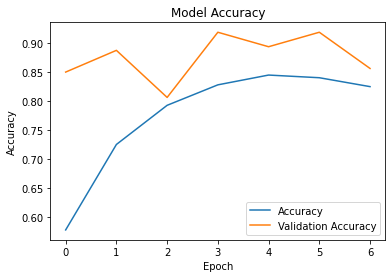

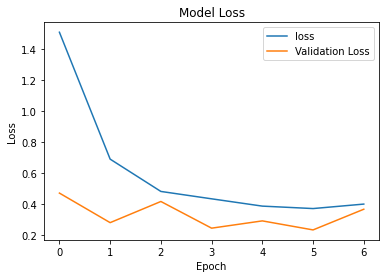

In [116]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [117]:
test_generator.reset()

In [118]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


6/6 [==============================] - 4s 611ms/step


In [119]:
print(pred[0:10])
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:25])

[[9.0030664e-01 9.9693358e-02]
 [9.8976594e-01 1.0234034e-02]
 [9.9920064e-01 7.9940690e-04]
 [7.7069673e-04 9.9922931e-01]
 [7.5968361e-04 9.9924028e-01]
 [6.2456170e-06 9.9999380e-01]
 [9.9552274e-01 4.4772145e-03]
 [4.7430306e-04 9.9952567e-01]
 [1.7970950e-04 9.9982029e-01]
 [4.0408257e-05 9.9995959e-01]]
[0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0]


In [120]:
print(len(predicted_class_idx))

213


In [121]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

7/7 [==============================] - 3s 162ms/step - loss: 0.2671 - accuracy: 0.8732


[0.26711612939834595, 0.8732394576072693]

In [122]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

In [123]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]
pred_labels[1:25]

['cataract',
 'cataract',
 'normal',
 'normal',
 'normal',
 'cataract',
 'normal',
 'normal',
 'normal',
 'cataract',
 'cataract',
 'normal',
 'normal',
 'cataract',
 'normal',
 'cataract',
 'cataract',
 'normal',
 'normal',
 'normal',
 'normal',
 'cataract',
 'normal',
 'cataract']

In [124]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,3088_left.jpg,cataract
1,2180_right.jpg,cataract
2,769_right.jpg,cataract
3,2778_right.jpg,normal
4,3411_right.jpg,normal


In [125]:
prediction_df.iloc[35]

Filename      3428_left.jpg
Prediction           normal
Name: 35, dtype: object

In [126]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

3428_left.jpg
1


In [127]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Wrong     cataract    normal      3088_left.jpg
 Correct   cataract    cataract      2180_right.jpg
 Correct   cataract    cataract      769_right.jpg
 Correct   normal    normal      2778_right.jpg
 Correct   normal    normal      3411_right.jpg
 Correct   normal    normal      2504_left.jpg
 Correct   cataract    cataract      103_left.jpg
 Correct   normal    normal      1038_left.jpg
 Correct   normal    normal      2568_left.jpg
 Correct   normal    normal      3151_right.jpg
 Correct   cataract    cataract      2109_right.jpg
 Correct   cataract    cataract      1115_left.jpg
 Correct   normal    normal      751_right.jpg
 Correct   normal    normal      381_right.jpg
 Correct   cataract    cataract      2163_left.jpg
 Correct   normal    normal      2423_right.jpg
 Correct   cataract    cataract      2195_left.jpg
 Correct   cataract    cataract      2226_left.jpg
 Correct   normal    normal      142

In [128]:
x_test, y_test = test_generator.next()

In [129]:
print(len(x_test))
print(len(y_test))


## compare this length to our prediction data and notice the difference.  

print(len(pred))

32
32
213


In [130]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 [==============================] - 0s 263ms/step - loss: 0.1481 - accuracy: 0.9375
loss: 0.14809168875217438
Accuracy: 0.9375


In [131]:
test_image_data, test_labels = test_generator.next()

In [132]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [133]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

3088_left.jpg
1


'cataract'

In [134]:
test_labels[5]

array([0., 1.], dtype=float32)

In [135]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

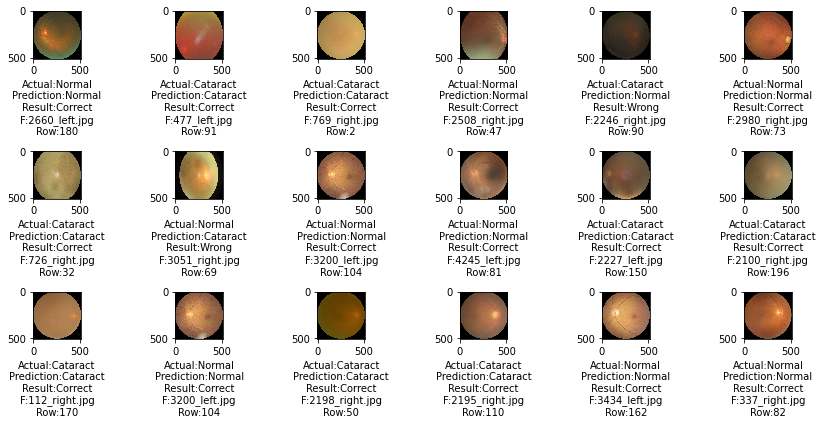

In [136]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
           
    
    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout() 

In [138]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Cataract       0.91      0.83      0.87       105
      Normal       0.85      0.92      0.88       108

    accuracy                           0.87       213
   macro avg       0.88      0.87      0.87       213
weighted avg       0.88      0.87      0.87       213



In [139]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[87, 18],
       [ 9, 99]])

In [140]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [142]:
cm_plot_labels = ['cataract','normal']

Confusion matrix, without normalization
[[87 18]
 [ 9 99]]


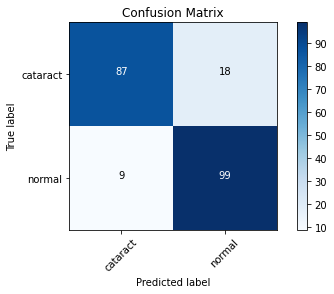

In [143]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')